In [1]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
import math
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from dataset import get_dataset
from utils import alphabar_t
from model import Model
from generate import train_sample
from model2 import Unet
import os

torch.backends.cudnn.benchmark = True


/home/bigbrainman/deepvenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
T = 35
S = 0.0008
BATCH_SIZE = 128

In [3]:
train_set = get_dataset(T)

Files already downloaded and verified


In [4]:
g = make_grid([train_set[random.randint(0, len(train_set) -1)][2] for _ in range(25)], 5)

torch.Size([3, 32, 32])


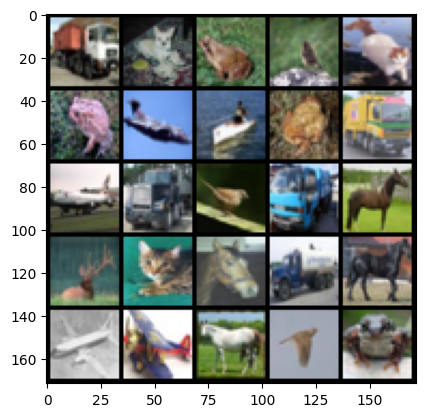

In [5]:
plt.imshow(g.permute(1, 2, 0))
print(train_set[0][0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


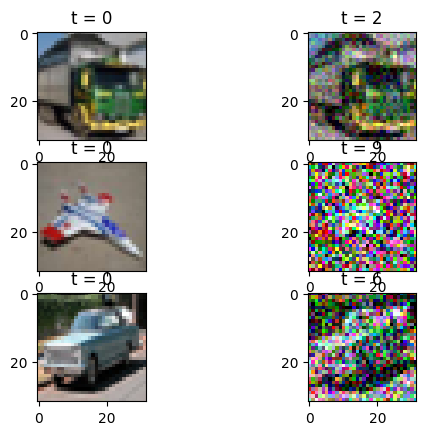

In [6]:
fig, axes = plt.subplots(3, 2)

for i in range(3):
    idx = random.randint(1, T - 1)
    axrow = axes[i]

    noise_img, eps, img, t = train_set[idx]

    axrow[0].imshow(img.permute(1, 2, 0), cmap='gray')
    axrow[0].set_title('t = 0')

    axrow[1].imshow(noise_img.permute(1, 2, 0), cmap='gray')
    axrow[1].set_title(f"t = {t}")

In [7]:
# net = Model(u_depth = 5, block_size=3, h_channels = 10).to(device)
image_size = 32

channels = 3

net = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
).to(device)

iters = 0

model_dir = './models2'

if os.path.exists(model_dir) and len(list(os.walk(model_dir))[0][2]) >= 2:

    highest = 0
    for p in list(os.walk(model_dir))[0][2]:
        
        highest = max(highest, int(os.path.splitext(p)[0]))

    print(f"loading {highest}")
    path = f'{model_dir}/{highest}.pth'
    print(path)
    net.load_state_dict(torch.load(path))
    iters = highest

summary(net, (3, 32, 32), device=device)



No time!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 32, 32]           2,960
SinusoidalPositionEmbeddings-2                   [-1, 32]               0
            Linear-3                  [-1, 128]           4,224
              GELU-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
            Conv2d-6           [-1, 20, 32, 32]           1,000
              GELU-7                  [-1, 128]               0
            Linear-8                   [-1, 20]           2,580
         GroupNorm-9           [-1, 20, 32, 32]              40
           Conv2d-10           [-1, 64, 32, 32]          11,584
             GELU-11           [-1, 64, 32, 32]               0
        GroupNorm-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 32, 32, 32]          18,464
           Conv2d-14

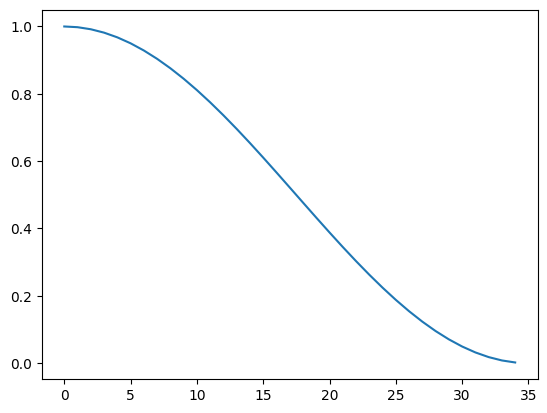

In [8]:
# precache the alpha_bars
a_bar = alphabar_t(torch.arange(0, T), T, S)

plt.plot(a_bar)


In [9]:
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=0.0001, amsgrad=True)

In [11]:
iters_print = 20

iters_generate = 200


for i in range(100):
    print_loss = 0

    for noise_img, eps, img, t in train_dl:


        noise_img = noise_img.to(device)
        eps = eps.to(device)
        t = t.to(device)

        net.train()

        out = net(noise_img, t)

        loss = loss_fn(out, eps)

        optim.zero_grad()

        loss.backward()

        optim.step()

        print_loss += loss.item()


        iters += 1

        if iters % iters_print == 0:
            l = print_loss / iters_print
            print_loss = 0
            print(f"[iter {iters}] loss: {l}")


        if iters % iters_generate == 0:
            torch.save(net.state_dict(), f'./models/{iters}.pth')
            net.eval()
            with torch.no_grad():
                train_sample(20, T, net, iters, shape=(3, 32, 32))


[iter 20] loss: 1.029559111595154
[iter 40] loss: 0.9940861970186233
[iter 60] loss: 0.976106920838356
[iter 80] loss: 0.9260307192802429
[iter 100] loss: 0.8503339350223541
[iter 120] loss: 0.7736392498016358
[iter 140] loss: 0.6997865200042724
[iter 160] loss: 0.6314938783645629
[iter 180] loss: 0.5653786987066269
[iter 200] loss: 0.5056674659252167


100%|██████████| 34/34 [00:00<00:00, 103.22it/s]


[iter 220] loss: 0.4491188883781433
[iter 240] loss: 0.39615885317325594
[iter 260] loss: 0.3560516834259033
[iter 280] loss: 0.32286079227924347
[iter 300] loss: 0.29309181571006776
[iter 320] loss: 0.2727284595370293
[iter 340] loss: 0.25893114879727364
[iter 360] loss: 0.247550867497921
[iter 380] loss: 0.23488934561610222
